# read datas

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import json
import numpy as np
import pandas as pd

with open('./tmp/typeid.json') as f:
    typeid = json.load(f)
with open('./tmp/bw_result.json') as f:
    typebw = json.load(f)
rentdf = pd.read_csv('./tmp/170911_rentclear.csv')
envdf = pd.read_csv('./tmp/env_clear.csv')

In [11]:
typebw

{'101': 300,
 '102': 2100,
 '201': 900,
 '202': 4300,
 '203': 3500,
 '204': 6900,
 '205': 1700,
 '206': 5400,
 '207': 6000,
 '301': 2400,
 '302': 1200,
 '303': 4800,
 '304': 4100,
 '305': 2200,
 '401': 1600,
 '402': 1300,
 '403': 1400,
 '501': 4000,
 '502': 5800,
 '503': 3500,
 '504': 6900,
 '505': 6900}

In [29]:
rentdf.shape

(20937, 11)

In [4]:
envdf.head()

,Unnamed: 0,ID,cityID,typeID,cost,lat,lng
0,0,1,104,101,300,25.056030,121.544220
1,1,2,235,101,150,25.002616,121.472260
2,2,3,241,101,145,25.066205,121.498771
3,3,4,106,101,745,25.026635,121.551803
4,4,5,110,101,64,25.039510,121.576738


In [12]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

In [22]:
%%time
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))
col = '{}:{}'
tmpdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    data = list(map(c.convert,envdf[envdf.typeID==int(key)].loc[:,['lat','lng']].values))
    kde = KernelDensity(bandwidth=bw)
    kde.fit(data)
    tmpdf[name] = kde.score_samples(rentdata)

CPU times: user 1min 4s, sys: 51.6 ms, total: 1min 4s
Wall time: 1min 4s


In [105]:
tmpdf.columns

Index(['101:Food', '102:Supermarket', '201:Bus', '202:MRT', '203:UBike',
       '204:Train', '205:Exam', '206:Charger', '207:Towing', '301:BookStore',
       '302:DepartmentStore', '303:Library', '304:Museum', '305:Theater',
       '401:Park', '402:Scenic', '403:Sport', '501:School', '502:Hospital',
       '503:Pharmacy', '504:Police', '505:FireStation'],
      dtype='object')

In [106]:
expdf = tmpdf.applymap(lambda x:np.exp(x))

In [55]:
expdf.head(3)

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,3.215294e-05,0.000026,0.000025,0.000017,0.000016,0.000007,0.000031,0.000019,0.000019,0.000027,...,0.000023,2.336993e-08,0.000049,0.000058,0.000038,0.000019,0.000020,0.000008,0.000018,0.000018
1,4.091638e-07,0.000018,0.000014,0.000011,0.000013,0.000004,0.000015,0.000015,0.000018,0.000017,...,0.000019,8.506062e-10,0.000033,0.000025,0.000019,0.000015,0.000016,0.000005,0.000014,0.000015
2,4.369946e-05,0.000024,0.000019,0.000019,0.000017,0.000008,0.000029,0.000020,0.000019,0.000026,...,0.000024,1.009795e-07,0.000038,0.000044,0.000033,0.000020,0.000022,0.000011,0.000019,0.000020


In [141]:
#df = rentdf.join(tmpdf)
df = rentdf.join(expdf)

In [142]:
yn = {'N':0,'Y':1}
df['pet'] = df.pet.map(lambda x: yn.get(x))

In [143]:
df = df[['pet', 'rent', 'space', '101:Food', '102:Supermarket', '201:Bus', '202:MRT', '203:UBike',
       '204:Train', '205:Exam', '206:Charger', '207:Towing', '301:BookStore',
       '302:DepartmentStore', '303:Library', '304:Museum', '305:Theater',
       '401:Park', '402:Scenic', '403:Sport', '501:School', '502:Hospital',
       '503:Pharmacy', '504:Police', '505:FireStation']]

In [145]:
from sklearn.preprocessing import Normalizer

nml = Normalizer()
X = nml.fit_transform(df)

In [156]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
X = sc.fit_transform(df)

In [195]:
# 直接使用scikit-learn實作
from sklearn.cluster import KMeans
# n_init=10, 隨機做十次  自動找出SSE最小的那一次
# max_iter=300, 或是 tol=1e-04, 為中止條件
clus = 6

km = KMeans(n_clusters=clus, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)


In [196]:
y_km = km.fit_predict(X)


Eigenvalues 
[  1.51905691e+01   3.78017062e+00   1.59936324e+00   1.33495504e+00
   9.67045141e-01   7.63029369e-01   2.78245025e-01   2.44953039e-01
   2.26997054e-01   1.50701899e-01   1.38337191e-01   1.20413439e-01
   7.36170416e-02   4.81597900e-02   3.80013270e-02   1.75208209e-02
   1.24533247e-02   8.91631560e-03   2.60195096e-03   2.36894427e-03
   1.58416910e-03   7.18084665e-04   3.07192995e-04   9.31087137e-05
   7.19260918e-05]


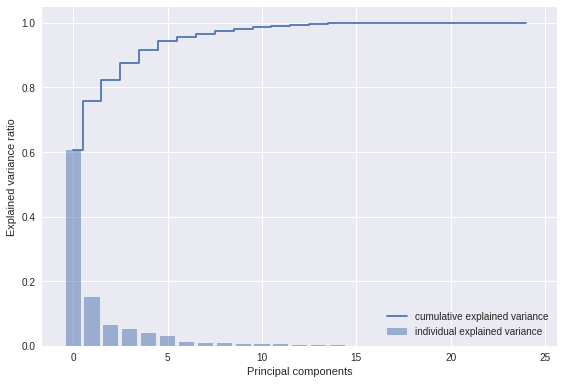

In [178]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
# 將特徵值排序  並計算百分比
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 加總
cum_var_exp = np.cumsum(var_exp)


length = len(X.T)
plt.bar(range(0, length), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, length), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [160]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low

eigen_pairs.sort(reverse=True)

# 取前兩名重要的向量  並排列整齊
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

X_pca = X.dot(w)

In [197]:
X_end = pd.DataFrame(X_pca,columns=['x','y'])
X_end['y_km'] = y_km

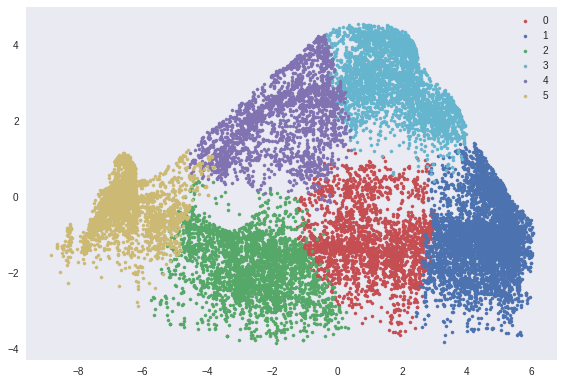

In [198]:
# 作圖

colors = ['r', 'b', 'g', 'c', 'm', 'y']

for l, c in zip(range(clus), colors):
    plt.scatter(X_end[y_km == l].x , 
                X_end[y_km == l].y, 
                c=c, label=l, s=10)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [167]:
X_df = pd.DataFrame(X,columns=['pet', 'rent', 'space', '101:Food', '102:Supermarket', '201:Bus', '202:MRT', '203:UBike',
       '204:Train', '205:Exam', '206:Charger', '207:Towing', '301:BookStore',
       '302:DepartmentStore', '303:Library', '304:Museum', '305:Theater',
       '401:Park', '402:Scenic', '403:Sport', '501:School', '502:Hospital',
       '503:Pharmacy', '504:Police', '505:FireStation'])

In [168]:
resultdf = rentdf.join(X_df ,how='left', lsuffix='_left', rsuffix='_right')

In [192]:
resultdf['y'] = y_km

In [199]:
resultdf.groupby('y').count().ID

y
0    4921
1    3972
2    3070
3    5911
4    3063
Name: ID, dtype: int64

In [200]:
resultdf.groupby('y').mean().T[3:]

y,0,1,2,3,4
rent_left,15485.768746,30482.735398,14741.847231,35267.119269,29628.656872
space_left,17.352993,29.041161,23.853033,24.175994,22.813803
lat,25.025957,25.064231,25.111412,25.044596,25.049257
lng,121.478942,121.532639,121.453080,121.532566,121.552444
floor,4.871774,5.093152,5.965147,5.767890,4.876592
unit,1087.639447,1137.516290,770.709612,1615.757456,1429.040927
pet_right,-0.005029,-0.001238,-0.059706,0.066031,-0.057900
rent_right,-0.439952,0.195088,-0.471453,0.397681,0.158923
space_right,-0.293615,0.288477,0.030098,0.046183,-0.021657
101:Food,-0.310452,-0.626311,-0.611658,1.110294,-0.218647


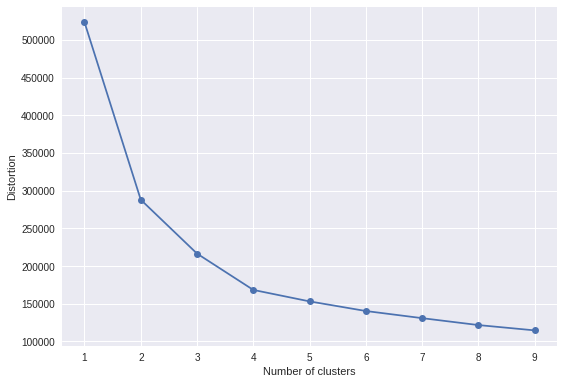

In [187]:
# 如果選取k越大 SSE必然越小
# 但分太多類別也沒有意義
# 這邊藉由SSE 的變化來選擇要分幾類
distortions = []
sup = 10
for i in range(1, sup):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, sup), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()